# Imports

In [1]:
import os, re, sys, pickle, datetime
import itertools
from itertools import repeat
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import stats
import seaborn as sns
import copy

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA,NMF
from sklearn.ensemble import RandomForestClassifier,RandomForestRegressor,GradientBoostingRegressor
from sklearn.feature_selection import SelectKBest,f_regression,mutual_info_regression
from sklearn.kernel_ridge import KernelRidge
from sklearn.linear_model import LogisticRegression,Lasso,LinearRegression,Ridge,ElasticNetCV,ElasticNet,Lars,LassoCV,RidgeCV,LarsCV,LassoLarsCV,LassoLarsIC,OrthogonalMatchingPursuitCV,OrthogonalMatchingPursuit
from sklearn.manifold import TSNE,MDS
from sklearn import metrics
from sklearn.metrics import confusion_matrix,f1_score
from sklearn.model_selection import train_test_split,GridSearchCV,RepeatedKFold,LeaveOneOut,cross_val_score,cross_validate
from sklearn.multioutput import MultiOutputRegressor
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier,MLPRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler,MinMaxScaler,PolynomialFeatures
from sklearn.svm import LinearSVC,SVR
from sklearn.tree import DecisionTreeClassifier,DecisionTreeRegressor
#from sklearn import tree

import statsmodels.api as sm
import multiprocessing
from multiprocessing import Pool
n_processors = max([1,multiprocessing.cpu_count()-2])
from joblib import Parallel,delayed

import warnings
warnings.filterwarnings("ignore")

# import loo_q2 as loo
from hotspot_classes import Threshold, Hotspot
import hotspot_utils
import mlr_utils

randomstate = 42

def plot_fit(y_train,y_pred_train,y_test,y_pred_test,leg=True,sav=False,label="y",loo_pred=[]):
    y_orig_min = np.min(np.hstack((y_train,y_test)))
    y_pred_min = np.min(np.hstack((y_pred_train,y_pred_test)))
    y_orig_max = np.max(np.hstack((y_train,y_test)))
    y_pred_max = np.max(np.hstack((y_pred_train,y_pred_test)))
    delta_x = 0.04 * (y_orig_max-y_orig_min)
    delta_y = 0.04 * (y_pred_max-y_pred_min)
           
    yy_fit = np.polyfit(y_train,y_pred_train,deg=1)
    yy_fit_line = yy_fit[1]+yy_fit[0]*y_train
    
    plt.figure(figsize=(5,5))
    # plt.plot(np.linspace(y_orig_min-delta_x,y_orig_max+delta_x), np.linspace(y_orig_min-delta_x,y_orig_max+delta_x),color="grey")
    plt.xlim([y_orig_min-delta_x,y_orig_max+delta_x])
    plt.ylim([y_pred_min-delta_y,y_pred_max+delta_y])
    if len(loo_pred) != 0:
        plt.scatter(y_train,loo_train,label="LOO",color="black",marker=".",facecolor='none',s=200)
    plt.scatter(y_train,y_pred_train,label="training",color="black",marker=".",s=200) # ,alpha=0.6
    plt.scatter(y_test,y_pred_test,label="test",color='red',marker=".",linewidth=3, s=200)     #,alpha=0.25  "#8da9f5"
    plt.plot(y_train,yy_fit_line,color="darkgrey",linestyle='--',dashes=[5,15]) #,alpha=0.2
    if leg:
        plt.legend(loc='lower right', fontsize=10)
    plt.xlabel(label+" measured",fontsize=18, fontweight='bold')
    plt.ylabel(label+" predicted",fontsize=18, fontweight='bold')
    
    plt.xticks(fontsize=18)
    plt.yticks(fontsize=18)
    
    plt.gca().spines['right'].set_color('none')
    plt.gca().spines['top'].set_color('none')
    
    if not sav:
        plt.show()  
    else:
        plt.savefig(sav, dpi=300, bbox_inches='tight', transparent=True)
        
# def r2_val(y_test,y_pred_test,y_train):
#     """Calculates the external R2 pred as described:
#     https://pdfs.semanticscholar.org/4eb2/5ff5a87f2fd6789c5b9954eddddfd1c59dab.pdf"""
#     y_resid = y_pred_test - y_test
#     SS_resid = np.sum(y_resid**2)
#     y_var = y_test - np.mean(y_train)
#     SS_total = np.sum(y_var**2)
#     r2_validation = 1-SS_resid/SS_total
#     return(r2_validation)

# def repeated_k_fold(X_train,y_train,reg = LinearRegression(), k=3, n=100):
#     """Reapeated k-fold cross-validation. 
#     For each of n repeats, the (training)data is split into k folds. 
#     For each fold, this part of the data is predicted using the rest. 
#     Once this is done for all k folds, the coefficient of determination (R^2) of the predictions of all folds combined (= the complete data set) is evaluated
#     This is repeated n times and all n R^2 are returned for averaging/further analysis
#     """
    
#     rkf = RepeatedKFold(n_splits=k, n_repeats=n)
#     r2_scores = []
#     y_validations,y_predictions = np.zeros((np.shape(X_train)[0],n)),np.zeros((np.shape(X_train)[0],n))
#     foldcount = 0
#     for i,foldsplit in enumerate(rkf.split(X_train)):
#         fold, rep = i%k, int(i/k) # Which of k folds. Which of n repeats
#         model = reg.fit(X_train[foldsplit[0]],y_train[foldsplit[0]]) # foldsplit[0]: k-1 training folds
#         y_validations[foldcount:foldcount+len(foldsplit[1]),rep] = y_train[foldsplit[1]] # foldsplit[1]: validation fold
#         y_predictions[foldcount:foldcount+len(foldsplit[1]),rep]  = model.predict(X_train[foldsplit[1]])
#         foldcount += len(foldsplit[1])
#         if fold+1==k:
#             foldcount = 0
#     r2_scores = np.asarray([metrics.r2_score(y_validations[:,rep],y_predictions[:,rep]) for rep in range(n)])
#     return(r2_scores)

import random

with open('insults.txt', 'r') as f:
    insults = f.read().splitlines()

# Reading data - Works for single or double file layouts

In [2]:
# This cell reads in parameters and response data from Excel files and combines them into a single dataframe
# It assumes a row of xID numbers, followed by a row of full parameter names
# Check cell outputs to make sure everything looks good

parameters_file = "Multi-Threshold Analysis Data" # Excel file to pull parameters from
parameters_sheet = "Suzuki Yields and Parameters" # Sheet in the Excel file to pull parameters from
parameters_start_col = 3   # 0-indexed column number where the parameters start
parameters_num_parameters = 190 # Number of parameters in the parameters file
parameters_num_responses = 450 # Number of responses/ligands in the parameters file
parameters_y_label_col = 0  # 0-indexed column number where the ligand labels are
parameters_header_rows = 0 # Number of rows to skip when reading the parameters

response_file = "Multi-Threshold Analysis Data" # Excel file to pull responses from
response_sheet = "Suzuki Yields and Parameters" # Sheet in the Excel file to pull responses from
response_num_samples = 450 # Number of samples/reactions in the response file
response_col = 1 # 0-indexed column number for the responses
response_y_label_col = 0  # 0-indexed column number where the ligand labels are
response_header_rows = 1 # Number of rows to skip when reading the responses

RESPONSE_LABEL = "Yield (%)"

# --------------------------------------------------------------------------------------------------------------
# EDIT ABOVE THIS LINE
# --------------------------------------------------------------------------------------------------------------

# Actually start reading stuff into dataframes
parameters_df = pd.read_excel("./InputData/" + parameters_file + ".xlsx",
                              parameters_sheet,
                              header = parameters_header_rows,
                              index_col = parameters_y_label_col,
                              nrows = parameters_num_responses + 1,
                              usecols = list(range(0, (parameters_num_parameters + parameters_start_col)))
                              )
response_df = pd.read_excel("./InputData/" + response_file + ".xlsx",
                            response_sheet,
                            header = response_header_rows,
                            index_col = response_y_label_col,
                            nrows = response_num_samples,
                            usecols = list(range(0, response_col + 1))
                            )


# Drop any columns before parameters_start_col that are not the index column
parameters_columns_to_keep = [col for col in range(0, len(parameters_df.columns)) if col >= parameters_start_col-1]
parameters_df = parameters_df.iloc[:,parameters_columns_to_keep]

# Combine the two dataframes into the master dataframe
response_df.drop(response_df.columns[0:response_col-1], axis = 'columns', inplace = True)
data_df = response_df.merge(parameters_df, left_index = True, right_index = True)
data_df.columns.values[0] = RESPONSE_LABEL # Converts the output column name from whatever it is on the spreadsheet
data_df.dropna(inplace = True) # This covers the entire masking section and trims the dataframe down to only the rows relevant to this dataset

# This converts all the data to numeric values since it was reading them in as non-numeric objects for some reason
for column in data_df.columns:
    data_df[column] = pd.to_numeric(data_df[column], errors='coerce')

# Creates a dictionary to convert x# labels to full parameter names
parameter_names = list(parameters_df.iloc[0, :parameters_num_parameters])
parameter_x_labels = list(parameters_df.columns)[:parameters_num_parameters]
x_labelname_dict = dict(zip(parameter_x_labels, parameter_names))

# Print out some information about the dataframe to confirm it was read in correctly
print("Parameter file shape: {}".format(parameters_df.shape))
print("Final parameter quantity: {}".format(len(parameter_x_labels)))
print("Final experiment quantity: {}".format(data_df.shape[0]))
print("First parameter cell: {}".format(data_df[parameter_x_labels[0]].iloc[0]))
print("Last parameter cell:  {}".format(data_df[parameter_x_labels[-1]].iloc[-1]))
print("First y: {}".format(data_df.iloc[0,0]))
print("Last y:  {}".format(data_df.iloc[-1,0]))
print("First reaction label: {}".format(data_df.index[0]))
print("Last reaction label:  {}".format(data_df.index[-1]))

display(data_df)

Parameter file shape: (451, 190)
Final parameter quantity: 190
Final experiment quantity: 450
First parameter cell: -0.063669988
Last parameter cell:  7.650386242
First y: 1.9165341260000002
Last y:  -12.1439
First reaction label: R1_2
Last reaction label:  R5_838


,Yield (%),x1,x2,x3,x4,x5,x6,x7,x8,x9,...,x181,x182,x183,x184,x185,x186,x187,x188,x189,x190
R1_2,1.916534,-0.063670,1.784157,-0.206310,-0.023277,-0.114794,0.183033,0.036033,0.061658,-0.345264,...,6.572514,6.339063,7.850955,1.511892,6.407769,7.285463,6.908743,8.216943,1.308200,7.992698
R1_5,98.000000,-0.061351,1.816461,-0.218842,-0.030145,-0.124494,0.188697,0.041069,0.060353,-0.376125,...,6.497622,6.092458,7.055260,0.962802,6.376705,7.370445,7.021018,8.155038,1.134020,8.086289
R1_6,0.617317,-0.071244,1.780166,-0.209940,0.016420,-0.096760,0.226360,0.020681,0.083040,-0.388780,...,6.443564,6.443564,6.443564,0.000000,6.443564,6.952513,6.952513,6.952513,0.000000,6.952513
R1_8,0.851423,-0.067185,1.780165,-0.216880,0.036010,-0.090435,0.252890,0.016170,0.113990,-0.456130,...,4.894739,4.894739,4.894739,0.000000,4.894739,6.648917,6.648917,6.648917,0.000000,6.648917
R1_10,4.908090,-0.067275,1.781649,-0.217025,0.020780,-0.098122,0.237805,0.020244,0.090149,-0.396203,...,6.615313,6.374532,7.124679,0.750147,6.377288,7.056268,7.037797,7.146163,0.108366,7.099058
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
R5_796,-13.206800,-0.024164,1.903453,-0.257967,-0.078693,-0.168330,0.179275,0.079036,0.006817,-0.407675,...,6.954069,6.028940,7.391170,1.362230,6.086104,6.989464,6.925771,7.430007,0.504236,7.430007
R5_797,-12.784600,-0.024191,1.900147,-0.256970,-0.079570,-0.168270,0.177400,0.079805,0.011430,-0.415940,...,6.027940,6.027940,6.029321,0.001381,6.029321,6.909132,6.909131,6.918910,0.009778,6.918910
R5_798,-13.645200,-0.026401,1.900154,-0.254050,-0.079880,-0.166965,0.174170,0.080029,0.005780,-0.411720,...,6.034069,6.029424,6.034070,0.004646,6.034070,6.910345,6.910344,6.919218,0.008874,6.910344
R5_799,-10.548200,-0.041824,1.902125,-0.234732,-0.074462,-0.154597,0.160270,0.074580,0.027824,-0.397857,...,6.041513,6.039198,6.050017,0.010818,6.039198,6.954143,6.941776,6.999585,0.057808,6.941776


# Basic visualization

## Histograms and univariate correlations

In [ ]:
# `features` should be a list of xID numbers you want to get the distribution and correlation for
# features = x_labels # Cycles through all features
features = ['x1','x2','x3'] # Gets the distribution and correlation for only the features listed

r2_cutoff = 0.0 # R^2 cutoff for correlation below which the feature will be skipped

# This feels like a relic of a bygone era, but here it is. 'matplotlib' refers to what was once the 'OG' cell.
visualization_type = 'seaborn' # 'matplotlib' or 'seaborn'

# --------------------------------------------------------------------------------------------------------------
# EDIT ABOVE THIS LINE
# --------------------------------------------------------------------------------------------------------------

for feature in features:
    print(f'{feature} - {x_labelname_dict[feature]}')

    # If the feature has no variance it would break the math later on, so we skip it
    if data_df[feature].std() == 0:
        print("No variance in feature. Skipping.")
        continue

    # Get stats and line of best fit
    slope, intercept, r_value, p_value, std_err = stats.linregress(data_df[feature], data_df[RESPONSE_LABEL])
    fit_line = intercept+slope*data_df[feature]

    # Skip the rest if R^2 is below the cutoff
    if r_value**2 < r2_cutoff:
        print("R^2 below cutoff. Skipping.")
        continue

    plt.figure(figsize=(9, 4))
    
    # Plot feature distribution
    plt.subplot(1,2,1)
    plt.hist(data_df[feature], bins=15)
    plt.ylabel("frequency",fontsize=15)
    plt.xlabel(f'{feature} {x_labelname_dict[feature]}',fontsize=15)
    plt.yticks(fontsize=12)
    plt.xticks(fontsize=12)

    # Plot univariate correlation
    plt.subplot(1,2,2)

    if visualization_type == 'matplotlib':
        plt.scatter(data_df[feature], data_df[RESPONSE_LABEL],color="black",marker="s",alpha=0.5)    
        plt.plot(data_df[feature],fit_line,color="black")
    elif visualization_type == 'seaborn':
        sns.set_style("white")
        sns.regplot(x=data_df[feature],y=data_df[RESPONSE_LABEL],ci=95,truncate=False)
        x_max=np.max(data_df[feature])
        x_min=np.min(data_df[feature])
        y_max=np.max(data_df[RESPONSE_LABEL])
        y_min=np.min(data_df[RESPONSE_LABEL])
        delta_x = 0.05 * (x_max-x_min)
        delta_y = 0.05 * (y_max-y_min)
        plt.xlim([x_min-delta_x,x_max+delta_x])
        plt.ylim([y_min-delta_y,y_max+delta_y])
    else:
        print(f'Invalid visualization type: {visualization_type}. Please fix and try again.')
        break

    plt.xlabel(f'{feature} {x_labelname_dict[feature]}',fontsize=15)
    plt.ylabel(RESPONSE_LABEL,fontsize=15)
    plt.yticks(fontsize=12)
    plt.xticks(fontsize=12) 

    plt.tight_layout()
    plt.show()    

    if p_value > 0.01:
        print("R^2 = {:.2f}; p-value = {:.2f}".format(r_value**2,p_value))
    else:
        print("R^2 = {:.2f}; p-value = {:.2E}".format(r_value**2,p_value))
    print("\n-------------------------------------------------------------------------------\n")   

## Plot a feature vs. another feature

In [ ]:
# iIDs_1 and xIDs_2 should be lists of xID numbers you want to get the correlation for
# Set them to x_labels to get the correlation for all features, or specify a list of features to compare
xIDs_1 = x_labels
xIDs_2 = x_labels

# xIDs_1 = ['x1']
# xIDs_2 = ['x2']

r2_cutoff = 0.0 # R^2 cutoff for correlation below which the feature pair will be skipped

# --------------------------------------------------------------------------------------------------------------
# EDIT ABOVE THIS LINE
# --------------------------------------------------------------------------------------------------------------

for feature_1,feature_2 in itertools.product(xIDs_1, xIDs_2):
    # No use wasting time comparing a feature to itself
    if feature_1 == feature_2:
        continue

    print(f'{feature_1} - {x_labelname_dict[feature_1]}')
    print(f'{feature_2} - {x_labelname_dict[feature_2]}')

    # If either feature has no variance it would break the math later on, so we skip it
    if data_df[feature_1].std() == 0 or data_df[feature_2].std() == 0:
        continue

    # Get stats and line of best fit
    slope, intercept, r_value, p_value, std_err = stats.linregress(data_df[feature_1], data_df[feature_2])
    fit_line = intercept+slope*data_df[feature_1]

    # Skip the rest if R^2 is below the cutoff
    if r_value**2 < r2_cutoff:
        print("R^2 below cutoff. Skipping.")
        print("\n-------------------------------------------------------------------------------\n")
        continue
    
    # Print p-values and R^2 values
    if p_value > 0.01:
        print("R^2 = {:.2f}; p-value = {:.2f}".format(r_value**2,p_value))
    else:
        print("R^2 = {:.2f}; p-value = {:.2E}".format(r_value**2,p_value))

    plt.figure(figsize=(16, 4))

    # Plot feature 1 distribution
    plt.subplot(1,3,1)
    plt.hist(data_df[feature_1], bins=15)
    plt.ylabel("frequency",fontsize=15)
    plt.xlabel(f'{feature} {x_labelname_dict[feature_1]}',fontsize=15)
    plt.yticks(fontsize=12)
    plt.xticks(fontsize=12)

    # Plot feature 2 distribution
    plt.subplot(1,3,2)
    plt.hist(data_df[feature_2], bins=15)
    plt.ylabel("frequency",fontsize=15)
    plt.xlabel(f'{feature} {x_labelname_dict[feature_2]}',fontsize=15)
    plt.yticks(fontsize=12)
    plt.xticks(fontsize=12)

    # Plot bivariate correlation
    plt.subplot(1,3,3)
    sns.set_style("white")
    sns.regplot(x=data_df[feature_1],y=data_df[feature_2],truncate=False)

    x_max=np.max(data_df[feature_1])
    x_min=np.min(data_df[feature_1])
    y_max=np.max(data_df[feature_2])
    y_min=np.min(data_df[feature_2])
    delta_x = 0.05 * (x_max-x_min)
    delta_y = 0.05 * (y_max-y_min)
    plt.xlim([x_min-delta_x,x_max+delta_x])
    plt.ylim([y_min-delta_y,y_max+delta_y])

    plt.xlabel(f'{feature_1} {x_labelname_dict[feature_1]}',fontsize=15)
    plt.ylabel(f'{feature_2} {x_labelname_dict[feature_2]}',fontsize=15)
    plt.yticks(fontsize=12)
    plt.xticks(fontsize=12) 

    # Show the plots
    plt.tight_layout()
    plt.show()
    print("\n-------------------------------------------------------------------------------\n")
    

## Correlation Map

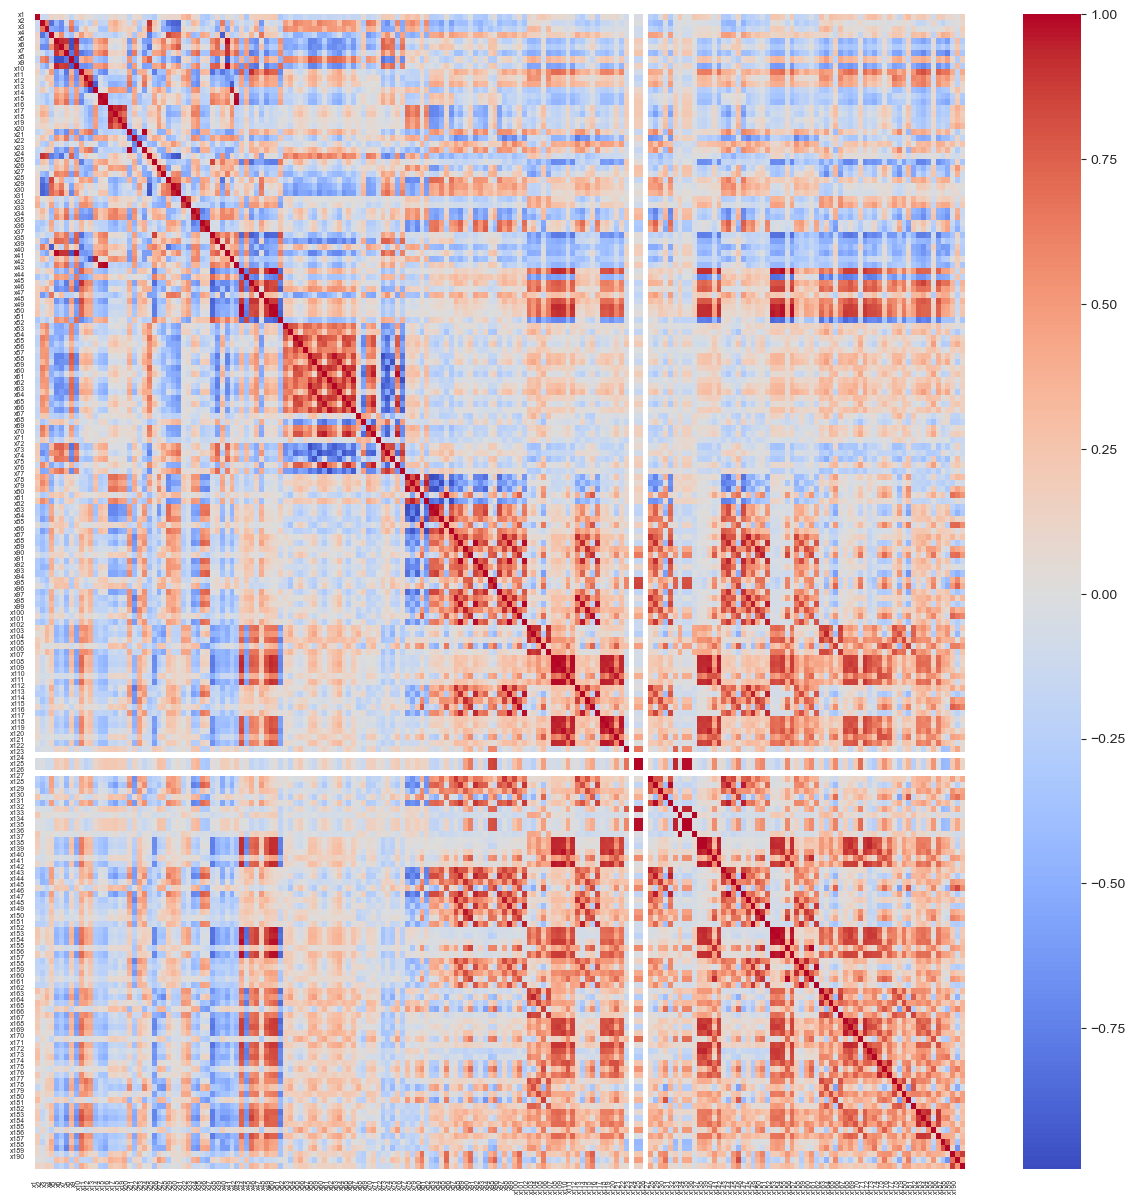

In [30]:
# Run to see how correlated the features are with each other

corrmap = data_df.corr()

plt.subplots(figsize=(15,15))
sns.heatmap(corrmap,center=0, annot=False, cmap="coolwarm", cbar=True) #linewidths=0.5
plt.xticks(range(len(x_labels)),x_labels, fontsize=5, rotation=90)
plt.yticks(range(len(x_labels)),x_labels, fontsize=5)
plt.show()

# Threshold Analysis

## Train / Test split

Training Set: ['R1_2', 'R1_5', 'R1_6', 'R1_8', 'R1_10', 'R1_11', 'R1_12', 'R1_14', 'R1_20', 'R1_21', 'R1_22', 'R1_30', 'R1_32', 'R1_44', 'R1_53', 'R1_64', 'R1_65', 'R1_68', 'R1_70', 'R1_79', 'R1_82', 'R1_88', 'R1_89', 'R1_90', 'R1_103', 'R1_104', 'R1_117', 'R1_133', 'R1_137', 'R1_157', 'R1_158', 'R1_159', 'R1_162', 'R1_163', 'R1_165', 'R1_168', 'R1_169', 'R1_170', 'R1_171', 'R1_175', 'R1_176', 'R1_179', 'R1_180', 'R1_182', 'R1_184', 'R1_185', 'R1_186', 'R1_187', 'R1_196', 'R1_208', 'R1_233', 'R1_239', 'R1_243', 'R1_249', 'R1_251', 'R1_252', 'R1_260', 'R1_266', 'R1_276', 'R1_277', 'R1_280', 'R1_281', 'R1_292', 'R1_295', 'R1_296', 'R1_299', 'R1_303', 'R1_309', 'R1_310', 'R1_311', 'R1_314', 'R1_320', 'R1_323', 'R1_327', 'R1_337', 'R1_340', 'R1_344', 'R1_487', 'R1_566', 'R1_584', 'R1_608', 'R1_720', 'R1_735', 'R1_739', 'R1_795', 'R1_796', 'R1_797', 'R1_798', 'R1_799', 'R1_838', 'R2_2', 'R2_5', 'R2_6', 'R2_8', 'R2_10', 'R2_11', 'R2_12', 'R2_14', 'R2_20', 'R2_21', 'R2_22', 'R2_30', 'R2_32', 

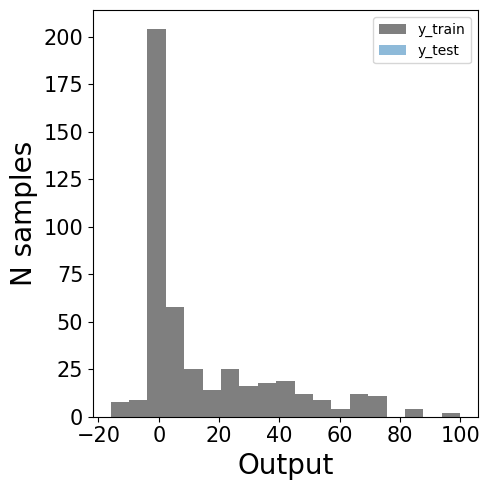

In [3]:
# Split options are 'random', 'ks', 'y_equidistant', 'define', 'none'
split = "none"
test_ratio = 0.3 

# New train_test_splits set up returns the data_df index labels for the relevant points
training_set, test_set = hotspot_utils.train_test_splits(data_df, split, test_ratio, x_labels, RESPONSE_LABEL)

## Automatic Threshold Analysis

In [4]:
# Cutoff in your output for what counts as an active ligand
y_cut = 10

# Set to True if you want points below the y-cut to be considered active
low_is_good = False

# How heavily to value active ligands (1) over inactive ligands (0)
class_weight = {1:10, 0:1} 

# How the prune_hotspots and find_best_hotspots evaluates which are the best
# Can be set to 'accuracy', 'weighted_accuracy', 'f1', and 'weighted_f1'
evaluation_method = 'weighted_accuracy'

# How many threshold dimensions do you want?
n_thresholds = 2

# What percentage of thresholds are analyzed in each subsequent step
percentage = 20

# --------------------------------------------------------------------------------------------------------------
# EDIT ABOVE THIS LINE
# --------------------------------------------------------------------------------------------------------------

# Set up y_class, the binary list of which y values are above y_cut
hotspot_data_df = copy.deepcopy(data_df)
hotspot_data_df['y_class'] = 0

if(low_is_good):
    for i in hotspot_data_df.index:
        hotspot_data_df.loc[i, 'y_class'] = int(hotspot_data_df.loc[i, RESPONSE_LABEL] < y_cut)
else:
    for i in hotspot_data_df.index:
        hotspot_data_df.loc[i, 'y_class'] = int(hotspot_data_df.loc[i, RESPONSE_LABEL] > y_cut)

# Find the best thresholds within the full X and y space and make single threshold hotspot objects from them
all_thresholds = hotspot_utils.threshold_generation(hotspot_data_df, class_weight, evaluation_method, x_labelname_dict)
best_hotspots = []
for thresh in all_thresholds:
    temp_hs = Hotspot(hotspot_data_df, [thresh], y_cut, training_set, test_set, evaluation_method, class_weight)
    best_hotspots.append(temp_hs)

# Cut down to the best {percentage} hotspots
best_hotspots = hotspot_utils.prune_hotspots(best_hotspots, percentage, evaluation_method)

# Add more thresholds, pruning after each step for resource management
for i in range(n_thresholds - 1):
    with Pool(processes=int(n_processors-2)) as p:
        new_hotspots = p.starmap(hotspot_utils.hs_next_thresholds_fast, zip(best_hotspots, repeat(all_thresholds)))
    new_hotspots = [item for sublist in new_hotspots for item in sublist] 
    
    best_hotspots = hotspot_utils.prune_hotspots(new_hotspots, percentage, evaluation_method)

best_hotspots.sort(key = lambda x: x.accuracy_dict[evaluation_method], reverse = True)

# print the top 5 hotspots
for i, hs in enumerate(best_hotspots[:5]):
    print(f'Hotspot Index: {i}')
    print(hs)
    hs.print_stats()
    print('\n**********************************\n')

Hotspot Index: 0
Total weighted_accuracy with 2 thresholds: 0.932
Initial weighted_accuracy with no thresholds: 0.847
Total accuracy with 2 thresholds: 0.793
Initial accuracy with no thresholds: 0.356
Thresholds: 
	x53 dipolemoment_max < 4.373 with Added weighted_accuracy of 0.031
	x87 vbur_vbur_min < 57.277 with Added weighted_accuracy of 0.054

                    all    train    test
         Accuracy: 0.793   0.793   0.000
Weighted Accuracy: 0.932   0.932   0.000
               F1: 0.770   0.770   0.000
      Weighted F1: 0.960   0.960   0.000

        Precision: 0.637
           Recall: 0.975

**********************************

Hotspot Index: 1
Total weighted_accuracy with 2 thresholds: 0.932
Initial weighted_accuracy with no thresholds: 0.847
Total accuracy with 2 thresholds: 0.793
Initial accuracy with no thresholds: 0.356
Thresholds: 
	x53 dipolemoment_max < 4.373 with Added weighted_accuracy of 0.031
	x90 vbur_vbur_vburminconf < 57.277 with Added weighted_accuracy of 0.054

 

## Manual Threshold Analysis

In [4]:
# What features do you want in your hotspot?
# For ranges, use data_df.columns[x:y].to_list() to get a list of feature xIDs
# For specific features, use ['xID1', 'xID2', ...]

manual_features = [['x1'], ['x87']]
# manual_features = [['x87']]
# manual_features = [['x1'], ['x87'], x_labels]

# Cutoff for what counts as a hit
y_cut = 10

# How heavily to value hits (1) over misses (0)
class_weight = {1:10, 0:1} 

# What percentage of hotspots to take through to each subsequent step
# Only relevant if using ranges instead of specific parameters
percentage = 100

# How the prune_hotspots and find_best_hotspots evaluates which are the best
# Can be set to 'accuracy', 'weighted_accuracy', 'f1', and 'weighted_f1'
evaluation_method = 'weighted_accuracy'

# Set to True if you want a hotspot of low output results (cold spot?)
low_is_good = False

# --------------------------------------------------------------------------------------------------------------
# EDIT ABOVE THIS LINE
# --------------------------------------------------------------------------------------------------------------

# Set up y_class, the binary list of which y values are above y_cut
hotspot_data_df = copy.deepcopy(data_df)
hotspot_data_df['y_class'] = 0

if(low_is_good):
    for i in hotspot_data_df.index:
        hotspot_data_df.loc[i, 'y_class'] = int(hotspot_data_df.loc[i, RESPONSE_LABEL] < y_cut)
else:
    for i in hotspot_data_df.index:
        hotspot_data_df.loc[i, 'y_class'] = int(hotspot_data_df.loc[i, RESPONSE_LABEL] > y_cut)

# Find the best thresholds within the full X and y space and make single threshold hotspot objects from them
all_thresholds = hotspot_utils.threshold_generation(hotspot_data_df, class_weight, evaluation_method, x_labelname_dict, manual_features[0])
best_hotspots = []
for thresh in all_thresholds:
    temp_hs = Hotspot(hotspot_data_df, [thresh], y_cut, training_set, test_set, evaluation_method, class_weight)
    best_hotspots.append(temp_hs)

# Cut down to the best {percentage} hotspots
best_hotspots = hotspot_utils.prune_hotspots(best_hotspots, percentage, evaluation_method)

# Add more thresholds, pruning after each step for resource management
for i in range(len(manual_features) - 1):
    new_hotspots = []
    for hs in best_hotspots:
        temp_hotspots = hotspot_utils.hs_next_thresholds(hs, hotspot_data_df, class_weight, x_labelname_dict, manual_features[i+1])
        new_hotspots.extend(temp_hotspots)
    best_hotspots = new_hotspots
    del (new_hotspots)
    best_hotspots = hotspot_utils.prune_hotspots(best_hotspots, percentage, evaluation_method)
    
best_hotspots.sort(key = lambda x: x.accuracy_dict[evaluation_method], reverse = True)
# print the top 5 hotspots
for i, hs in enumerate(best_hotspots[:5]):
    print(f'Hotspot Index: {i}')
    print(hs)
    hs.print_stats()
    print('\n**********************************\n')

Hotspot Index: 0
Total weighted_accuracy with 2 thresholds: 0.922
Initial weighted_accuracy with no thresholds: 0.847
Total accuracy with 2 thresholds: 0.813
Initial accuracy with no thresholds: 0.356
Thresholds: 
	x1 vmin_vmin_boltz < -0.046 with Added weighted_accuracy of 0.025
	x87 vbur_vbur_min < 57.277 with Added weighted_accuracy of 0.051

                    all    train    test
         Accuracy: 0.813   0.813   0.000
Weighted Accuracy: 0.922   0.922   0.000
               F1: 0.785   0.785   0.000
      Weighted F1: 0.954   0.954   0.000

        Precision: 0.665
           Recall: 0.956

**********************************



## Visualize Thresholds

Total weighted_accuracy with 2 thresholds: 0.922
Initial weighted_accuracy with no thresholds: 0.847
Total accuracy with 2 thresholds: 0.813
Initial accuracy with no thresholds: 0.356
Thresholds: 
	x1 vmin_vmin_boltz < -0.046 with Added weighted_accuracy of 0.025
	x87 vbur_vbur_min < 57.277 with Added weighted_accuracy of 0.051



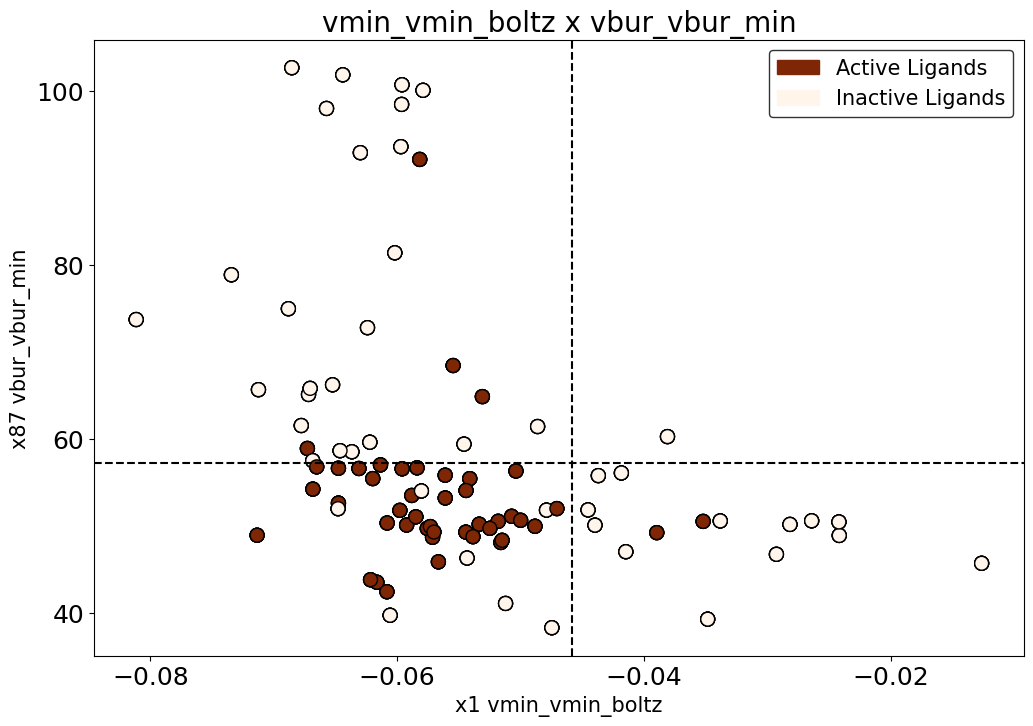

In [7]:
# For more direct control over plot style, changes can be made to functions in the cell above.
# The above functions must be run before this cell can be run.
hotspot_index =  0
print(best_hotspots[hotspot_index])

# subset can be 'all', 'training', or 'test'
# You can change the coloring to either 'scaled' or 'binary'
# output_label is whatever you call your output (Only relevant when using 'scaled' coloring or single threshold)
hotspot_utils.plot_threshold(best_hotspots[hotspot_index], 
                            subset='all', 
                            coloring='binary', 
                            output_label='Yield (%)', 
                            gradient_color='Oranges',
                            active_label='Active Ligands',
                            inactive_label='Inactive Ligands')

# Data preparation: Training/Test set split, Scaling

## Filter data before train/test split

In [31]:
# If you want to go forward with only data from the active space of a (multi)threshold, run this cell
# Select which hotspot you want to use based on the index from the Threshold Analysis section

hotspot_index = 0

# --------------------------------------------------------------------------------------------------------------

points_to_keep = best_hotspots[hotspot_index].get_hotspot_space()

print(f'Number of points before filtering: {len(data_df.index)}')
print(f'Number of points after filtering: {len(points_to_keep)}')

Number of points before filtering: 450
Number of points after filtering: 230


In [29]:
# If you want to use a custom cutoff in a certain parameter to limit which points you take forward, run this cell
# Set keep_points_below_cutoff to True if you want to keep points below the cutoff, False if you want to keep points above

cutoff_feature_xID = 'x1'
cutoff_value = -0.054
keep_points_below_cutoff = True

# --------------------------------------------------------------------------------------------------------------

points_to_keep = data_df.index.to_list()

for i in data_df.index:
    if keep_points_below_cutoff:
        if data_df.loc[i, cutoff_feature_xID] > cutoff_value:
            points_to_keep.remove(i)
    else:
        if data_df.loc[i, cutoff_feature_xID] < cutoff_value:
            points_to_keep.remove(i)

print(f'Number of points before filtering: {len(data_df.index)}')
print(f'Number of points after filtering: {len(points_to_keep)}')

Number of points before filtering: 450
Number of points after filtering: 290


In [27]:
# If you want to exclude specific points from both the training and test sets, run this cell
# Points are excluded by their index label

points_to_exclude = ['R1_2', 'R1_5', 'R1_6']

# --------------------------------------------------------------------------------------------------------------

points_to_keep = [point for point in data_df.index if point not in points_to_exclude]

print(f'Number of points before filtering: {len(data_df.index)}')
print(f'Number of points after filtering: {len(points_to_keep)}')

Number of points before filtering: 450
Number of points after filtering: 447


## Train/Test Set Split

Training Set: ['R1_2', 'R1_6', 'R1_8', 'R1_10', 'R1_20', 'R1_22', 'R1_30', 'R1_32', 'R1_53', 'R1_64', 'R1_70', 'R1_88', 'R1_89', 'R1_90', 'R1_103', 'R1_104', 'R1_133', 'R1_157', 'R1_162', 'R1_163', 'R1_165', 'R1_168', 'R1_169', 'R1_176', 'R1_179', 'R1_180', 'R1_182', 'R1_184', 'R1_186', 'R1_208', 'R1_233', 'R1_239', 'R1_243', 'R1_249', 'R1_251', 'R1_252', 'R1_260', 'R1_266', 'R1_276', 'R1_277', 'R1_280', 'R1_281', 'R1_292', 'R1_295', 'R1_296', 'R1_299', 'R1_303', 'R1_309', 'R1_311', 'R1_323', 'R1_327', 'R1_337', 'R1_340', 'R1_344', 'R1_487', 'R1_584', 'R1_608', 'R1_720', 'R1_735', 'R1_739', 'R1_796', 'R1_797', 'R1_798', 'R1_799', 'R1_838', 'R2_2', 'R2_8', 'R2_10', 'R2_12', 'R2_14', 'R2_30', 'R2_32', 'R2_64', 'R2_65', 'R2_70', 'R2_88', 'R2_89', 'R2_90', 'R2_103', 'R2_104', 'R2_117', 'R2_137', 'R2_163', 'R2_170', 'R2_175', 'R2_179', 'R2_180', 'R2_184', 'R2_196', 'R2_208', 'R2_233', 'R2_239', 'R2_243', 'R2_249', 'R2_251', 'R2_252', 'R2_260', 'R2_266', 'R2_276', 'R2_277', 'R2_280', 'R2_281

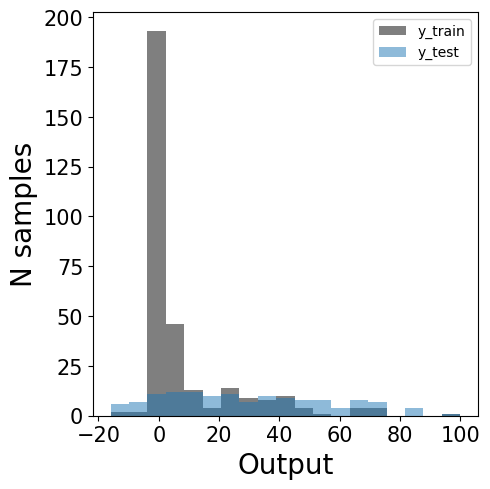

In [3]:
# Split options are 'random', 'ks', 'y_equidistant', 'define', 'none'
# If you want to pull the train and test sets from only the subset of your data defined above, set use_filtering to True

split = "y_equidistant"
test_ratio = 0.3 
use_filtering = False
use_scaling = True

# --------------------------------------------------------------------------------------------------------------

if use_filtering:
    training_set, test_set = hotspot_utils.train_test_splits(data_df, split, test_ratio, parameter_x_labels, RESPONSE_LABEL, subset=points_to_keep)
else:
    training_set, test_set = hotspot_utils.train_test_splits(data_df, split, test_ratio, parameter_x_labels, RESPONSE_LABEL)

if use_scaling:
    # Scales the parameters then puts them into modeling_data_df
    scaler = StandardScaler() # If you want to use a different scaler, change this line

    scaler.fit(data_df.loc[training_set, :])
    modeling_data = scaler.transform(data_df)
    modeling_data_df = pd.DataFrame(modeling_data, index = data_df.index, columns = data_df.columns)
    modeling_data_df[RESPONSE_LABEL] = data_df[RESPONSE_LABEL]
else:
    modeling_data_df = data_df

# Linear modelling - MLR

## Manual Feature Selection


Split method: ks
Test ratio: 0.3

Features: ['x101', 'x168', 'x140']

Parameters:
   13.7534 +
    2.0573 * x101 vbur_qvtot_min_boltz
    3.5593 * x168 sterimol_B5_max
   -1.5391 * x140 vbur_ovtot_max_vburminconf

Training R2  = 0.030
Training Q2  = 0.009
Training MAE = 16.224
Training K-fold R2 = 0.005 (+/- 0.000)

Test R2      = 0.036
Test MAE     = 19.795

If your models were any worse, they'd predict yesterday's weather.


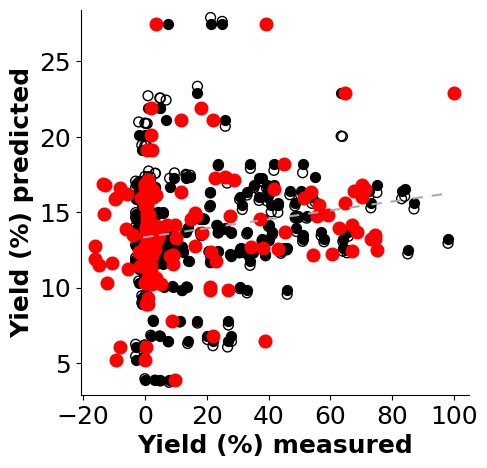

In [8]:
# Provide a list of the xIDs (as strings) for features to include in the model
features_selected = ['x101', 'x168', 'x140']

# --------------------------------------------------------------------------------------------------------------
# EDIT ABOVE THIS LINE
# --------------------------------------------------------------------------------------------------------------

# Break up the train/test data into smaller dataframes for easy reference
x_train = modeling_data_df.loc[training_set, features_selected] # Dataframe containing just the parameters used in this model for the ligands used in the training set
x_test = modeling_data_df.loc[test_set, features_selected] # Dataframe containing just the parameters used in this model for the ligands used in the test set
y_train = modeling_data_df.loc[training_set, RESPONSE_LABEL]
y_test = modeling_data_df.loc[test_set, RESPONSE_LABEL]

# Set up MLR and predict train/test
lr = LinearRegression().fit(x_train, y_train)
y_predictions_train = lr.predict(x_train)
y_predictions_test =  lr.predict(x_test)

# Calculate q2 and k-fold for the model
q2, loo_train = mlr_utils.calculate_q2(x_train, y_train)
kfoldscores = mlr_utils.repeated_k_fold(np.asarray(x_train), np.asarray(y_train), k=5, n=100)

# Print a bunch of stats about the model
print(f"\nSplit method: {split}")
print(f"Test ratio: {test_ratio}")
print(f"\nFeatures: {features_selected}")

print(f'\nParameters:\n{lr.intercept_:10.4f} +')
for i, parameter in enumerate(features_selected):
    print(f'{lr.coef_[i]:10.4f} * {parameter} {x_labelname_dict[parameter]}')

print(f"\nTraining R2  = {lr.score(x_train, y_train):.3f}")
print(f'Training Q2  = {q2:.3f}')
print(f"Training MAE = {metrics.mean_absolute_error(y_train,y_predictions_train):.3f}")
print("Training K-fold R2 = {:.3f} (+/- {:.3f})".format(kfoldscores.mean(), kfoldscores.std() ** 2))

print(f"\nTest R2      = {mlr_utils.external_r2(y_test,y_predictions_test,y_train):.3f}")
print(f'Test MAE     = {metrics.mean_absolute_error(y_test,y_predictions_test):.3f}')

# Print an insult if necessary
trainr2 = lr.score(x_train, y_train)
testr2 = lr.score(x_test, y_test)
if trainr2 - testr2 > 0.35 or trainr2 < 0.4 or testr2 < 0.2 or q2 < 0:
    print("\n" + random.choice(insults))

# Plot the model
plot_fit(y_train, y_predictions_train, y_test, y_predictions_test, leg=False, sav=False, label="Yield (%)", loo_pred=loo_train)

## Automatic Feature Selection

Starting 1 parameter models. Total time taken (sec): 0.02
Starting 2 parameter models. Total time taken (sec): 5.46
Starting 3 parameter models. Total time taken (sec): 62.76
	Finished running all 3 parameter models. Time taken (sec): 5.04
	Finished identifying best and unique models. Time taken (sec): 81.83
	Finished backwards step and filtering. Time taken (sec): 164.40
Done. Time taken (minutes): 5.23

Split method: ks
Test ratio: 0.3

Parameters:
   13.7534 +
  -11.7574 * x142 vbur_near_vbur_min
   12.0219 * x182 sterimol_burB5_min
    7.4979 * x71 qpoletens_zz_boltz

Training R2  = 0.408
Training Q2  = 0.397
Training MAE = 11.764
Training K-fold R2 = 0.396 (+/- 0.000)

Test R2      = 0.331
Test MAE     = 15.764


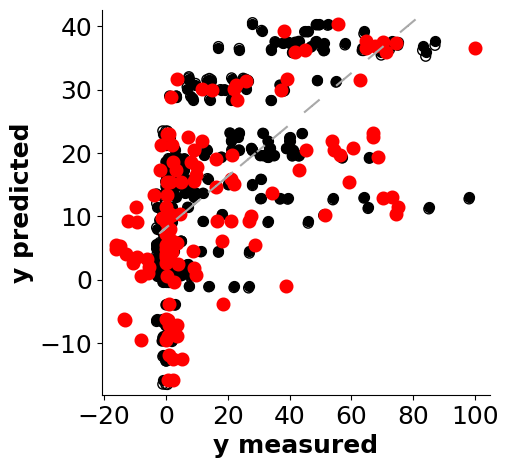

In [4]:
# Forward stepwise selection keeping a set of candidates at each step
n_steps = 3
n_candidates = 30
collinearity_cutoff = 0.5 # this is collinearity (r^2) above which parameters won't be included in the same model

# --------------------------------------------------------------------------------------------------------------
# EDIT ABOVE THIS LINE
# --------------------------------------------------------------------------------------------------------------

%notebook inline
plt.ioff()

# This is the function that actually does the MLR model search
results,models,sortedmodels,candidates = mlr_utils.bidirectional_stepwise_regression(modeling_data_df.loc[training_set,:],RESPONSE_LABEL,
                    n_steps=n_steps,n_candidates=n_candidates,collinearity_cutoff=collinearity_cutoff)

# Set up the test R^2 for each model
for i in results.index:
    model_terms = results.loc[i,"Model"]
    model = models[model_terms].model

    # Set test R^2 for each model
    x_test = modeling_data_df.loc[test_set, model_terms]
    y_test = modeling_data_df.loc[test_set, RESPONSE_LABEL]
    test_r2 = model.score(x_test, y_test)
    results.loc[i, 'Test R^2'] = test_r2

# Identify the best model from the ForwardStep algorithm
selected_model_terms = results.loc[0, "Model"] # Store a tuple of 'xIDs' for the best model
selected_model = models[selected_model_terms].model # Store the LinearRegression object for that model

# Break up the train/test data into smaller dataframes for easy reference
x_train = modeling_data_df.loc[training_set, selected_model_terms] # Dataframe containing just the parameters used in this model for the ligands used in the training set
x_test = modeling_data_df.loc[test_set, selected_model_terms] # Dataframe containing just the parameters used in this model for the ligands used in the test set
y_train = modeling_data_df.loc[training_set, RESPONSE_LABEL]
y_test = modeling_data_df.loc[test_set, RESPONSE_LABEL]

# Predict the train and test sets with the model
y_predictions_train = selected_model.predict(x_train)
y_predictions_test =  selected_model.predict(x_test)

# Calculate q2 and k-fold for the model
q2, loo_train = mlr_utils.calculate_q2(x_train,y_train)
kfoldscores = mlr_utils.repeated_k_fold(np.asarray(x_train), np.asarray(y_train), k=5, n=100)

# Print a bunch of stats about the model
print(f"\nSplit method: {split}")
print(f"Test ratio: {test_ratio}")

print(f'\nParameters:\n{selected_model.intercept_:10.4f} +')
for i, parameter in enumerate(selected_model_terms):
    print(f'{selected_model.coef_[i]:10.4f} * {parameter} {x_labelname_dict[parameter]}')

print(f"\nTraining R2  = {selected_model.score(x_train, y_train):.3f}")
print(f'Training Q2  = {q2:.3f}')
print(f"Training MAE = {metrics.mean_absolute_error(y_train,y_predictions_train):.3f}")
print("Training K-fold R2 = {:.3f} (+/- {:.3f})".format(kfoldscores.mean(), kfoldscores.std() ** 2))

print(f"\nTest R2      = {mlr_utils.external_r2(y_test,y_predictions_test,y_train):.3f}")
print(f'Test MAE     = {metrics.mean_absolute_error(y_test,y_predictions_test):.3f}')

# Print an insult if necessary
train_r2 = selected_model.score(x_train, y_train)
test_r2 = selected_model.score(x_test, y_test)
if train_r2 - test_r2 > 0.35 or train_r2<0.4 or test_r2<0.2 or q2<0:
    print("\n"+random.choice(insults))
    
# Plot the model
plot_fit(y_train, y_predictions_train, y_test, y_predictions_test, leg=False, sav=False, label="y", loo_pred=loo_train)

## Model Visualization

### Filter and View Multiple Models

In [5]:
# How many terms do you want in the largest model?
max_terms = 3
# What column to sort by? ('R^2', 'Q^2', 'Test R^2', 'Model Quality')
sort_column = 'Q^2'
# Only show models containing these features. Set to [] to show all models or a list of x# strings to filter.
include_features = [] 

# --------------------------------------------------------------------------------------------------------------
# EDIT ABOVE THIS LINE UNLESS YOU WANT TO CHANGE THE 'Model Quality' CALCULATION
# --------------------------------------------------------------------------------------------------------------

for i in results.index:
    model_terms = results.loc[i,"Model"]
    model = models[model_terms].model

    # Set model quality for each model.  This can be changed based on what's important to you.
    model_quality = results.loc[i,'R^2'] * results.loc[i,'Q^2'] * results.loc[i,'Test R^2']

    # Make sure two negative values don't cancel each other out to give a false positive
    if(results.loc[i,'R^2'] <= 0 or results.loc[i,'Q^2'] <= 0 or results.loc[i,'Test R^2'] <= 0):
        model_quality = -abs(model_quality)
    results.loc[i,'Model Quality'] = model_quality

# Sort and filter results
results.sort_values(by=[sort_column], ascending=False)
filtered_results = results[results.n_terms <= max_terms] # Filter out models with too many terms
for feature in include_features: # Filter out models that don't contain the specified features
    filtered_results = filtered_results[filtered_results['Model'].apply(lambda x: feature in x)]

print(filtered_results.head(20)) # Change this number if you want to see more models

                Model  n_terms       R^2       Q^2  Test R^2  Model Quality
0   (x142, x182, x71)        3  0.408002  0.397108  0.324903       0.052641
1   (x145, x182, x71)        3  0.407741  0.396847  0.324755       0.052549
2    (x142, x182, x7)        3  0.401291  0.390537  0.314487       0.049286
3    (x145, x182, x7)        3  0.401087  0.390332  0.314520       0.049240
4   (x127, x182, x71)        3  0.401379  0.390216  0.342307       0.053614
5    (x142, x182, x8)        3  0.399891  0.388776  0.300490       0.046717
6   (x142, x182, x56)        3  0.399790  0.388662  0.314823       0.048918
7    (x145, x182, x8)        3  0.399672  0.388555  0.300500       0.046666
8   (x145, x182, x56)        3  0.399541  0.388414  0.314691       0.048836
9   (x142, x182, x72)        3  0.397401  0.385757  0.321870       0.049343
10  (x145, x182, x72)        3  0.397260  0.385626  0.321838       0.049303
11  (x130, x182, x71)        3  0.396110  0.384781  0.332501       0.050678
12   (x141, 

### Display a Specific Model


Split method: ks
Test ratio: 0.3

Features: ('x182', 'x53', 'x92')

Parameters:
   13.7534 +
    7.1207 * x182 sterimol_burB5_min
   -5.6600 * x53 dipolemoment_max
   -9.8963 * x92 vbur_qvbur_min_min

Training R2  = 0.309
Training Q2  = 0.297
Training MAE = 12.732
Training K-fold R2 = 0.294 (+/- 0.000)

Test R2      = 0.266
Test MAE     = 15.805

did you get this model from Joe?


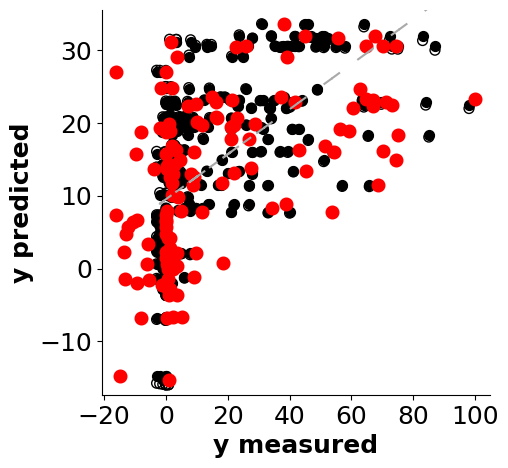

                            OLS Regression Results                            
Dep. Variable:              Yield (%)   R-squared:                       0.309
Model:                            OLS   Adj. R-squared:                  0.302
Method:                 Least Squares   F-statistic:                     46.38
Date:                Fri, 21 Jun 2024   Prob (F-statistic):           8.47e-25
Time:                        14:45:38   Log-Likelihood:                -1344.0
No. Observations:                 315   AIC:                             2696.
Df Residuals:                     311   BIC:                             2711.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         13.7534      0.978     14.064      0.0

R1_186    21.244722
R1_22      7.823855
R1_327     1.768271
R1_249    40.003322
R1_159     9.571511
            ...    
R4_176     3.306783
R4_179     1.423519
R4_180     2.031174
R4_182    39.329492
R4_184    34.102681
Name: Yield (%), Length: 315, dtype: float64

In [9]:
# Select model to display
model_index = 500

selected_model_terms = results.loc[model_index, "Model"] # Store a tuple of 'xIDs' for the best model
selected_model = models[selected_model_terms].model # Store the LinearRegression object for that model

# Break up the train/test data into smaller dataframes for easy reference
x_train = modeling_data_df.loc[training_set, selected_model_terms] # Dataframe containing just the parameters used in this model for the ligands used in the training set
x_test = modeling_data_df.loc[test_set, selected_model_terms] # Dataframe containing just the parameters used in this model for the ligands used in the test set
y_train = modeling_data_df.loc[training_set, RESPONSE_LABEL]
y_test = modeling_data_df.loc[test_set, RESPONSE_LABEL]

# Predict the train and test sets with the model
y_predictions_train = selected_model.predict(x_train)
y_predictions_test =  selected_model.predict(x_test)

# Calculate q2 and k-fold for the model
q2, loo_train = mlr_utils.calculate_q2(x_train,y_train)
kfoldscores = mlr_utils.repeated_k_fold(np.asarray(x_train), np.asarray(y_train), k=5, n=100)

# Print a bunch of stats about the model
print(f"\nSplit method: {split}")
print(f"Test ratio: {test_ratio}")
print(f"\nFeatures: {selected_model_terms}")

print(f'\nParameters:\n{selected_model.intercept_:10.4f} +')
for i, parameter in enumerate(selected_model_terms):
    print(f'{selected_model.coef_[i]:10.4f} * {parameter} {x_labelname_dict[parameter]}')

print(f"\nTraining R2  = {selected_model.score(x_train, y_train):.3f}")
print(f'Training Q2  = {q2:.3f}')
print(f"Training MAE = {metrics.mean_absolute_error(y_train,y_predictions_train):.3f}")
print("Training K-fold R2 = {:.3f} (+/- {:.3f})".format(kfoldscores.mean(), kfoldscores.std() ** 2))

print(f"\nTest R2      = {mlr_utils.external_r2(y_test,y_predictions_test,y_train):.3f}")
print(f'Test MAE     = {metrics.mean_absolute_error(y_test,y_predictions_test):.3f}')

# Print an insult if necessary
trainr2 = selected_model.score(x_train, y_train)
testr2 = selected_model.score(x_test, y_test)
if trainr2 - testr2 > 0.35 or trainr2<0.4 or testr2<0.2 or q2<0:
    print("\n"+random.choice(insults))
    
# Plot the model
plot_fit(y_train, y_predictions_train, y_test, y_predictions_test, leg=False, sav=False, label="y", loo_pred=loo_train)

# Print detailed model statistics
stats_model = sm.OLS(y_train, sm.add_constant(x_train)).fit()
print(stats_model.summary())

# Other Regression types that haven't been updated

## Ridge Regression, no feature selection 


Split method: y_equidist
Test ratio: 0.2

0.0001
     Training R2;Training Q2;Test R2;0.98;0.88;0.80
0.001
     Training R2;Training Q2;Test R2;0.98;0.88;0.80
0.01
     Training R2;Training Q2;Test R2;0.98;0.88;0.80
0.1
     Training R2;Training Q2;Test R2;0.98;0.88;0.79
1.0
     Training R2;Training Q2;Test R2;0.98;0.88;0.79
10.0
     Training R2;Training Q2;Test R2;0.96;0.81;0.72
100.0
     Training R2;Training Q2;Test R2;0.67;0.15;0.08
1000.0
     Training R2;Training Q2;Test R2;0.25;-0.06;-0.18
10000.0
     Training R2;Training Q2;Test R2;0.04;-0.07;-0.04


Using hyperparameter = 1.0


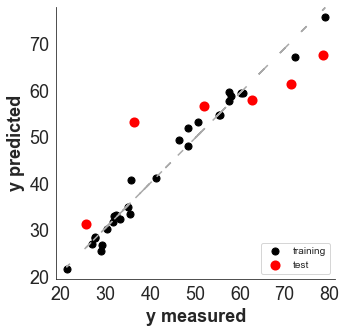

In [115]:
print("\nSplit method: {}".format(split))
print("Test ratio: {}\n".format(test_ratio))

linm = Ridge().fit(X_train_sc, y_train)

r2s = []
q2s = []
parms = []
parm_range = np.logspace(-4,4,9)
for parm in parm_range:
    print(parm)
    linm = Ridge(alpha=parm).fit(X_train_sc, y_train)
    q2,loo_train = loo.q2(X_train_sc,y_train,Ridge(alpha=parm))
    
    y_pred_train = linm.predict(X_train_sc)
    y_pred_test =  linm.predict(X_test_sc)
    #print("Training R2;Training Q2;Test R2;{:.2f};{:.2f};{:.2f}".format(lr.score(X_train_sel, y_train),q2,metrics.r2_score(y_pred_test,y_test)))
    print("     Training R2;Training Q2;Test R2;{:.2f};{:.2f};{:.2f}".format(linm.score(X_train_sc, y_train),q2,r2_val(y_test,y_pred_test,y_train)))
    #print(lr.score(X_train_sel,y_train),lr.score(X_test_sel,y_test))
        
    r2s.append(linm.score(X_train_sc, y_train))
    q2s.append(q2)
    parms.append(parm)

bestparm = parms[np.argmax(q2s)]
print("\n\nUsing hyperparameter = {}".format(bestparm))
linm = Ridge(alpha=bestparm).fit(X_train_sc, y_train)
y_pred_train = linm.predict(X_train_sc)
y_pred_test =  linm.predict(X_test_sc)
plot_fit(y_train,y_pred_train,y_test,y_pred_test)   

## Lasso feature selection


Split method: y_equidist
Test ratio: 0.2

0.0001
     Training R2;Training Q2;Test R2;0.98;-121400541232503030777118720.00;0.80
     Number of features used: 133
0.001
     Training R2;Training Q2;Test R2;0.98;-693238453438743368957952.00;0.80
     Number of features used: 62
0.01
     Training R2;Training Q2;Test R2;0.98;0.90;0.80
     Number of features used: 27
0.1
     Training R2;Training Q2;Test R2;0.98;0.90;0.80
     Number of features used: 20
1.0
     Training R2;Training Q2;Test R2;0.97;0.87;0.80
     Number of features used: 12
10.0
     Training R2;Training Q2;Test R2;0.77;0.73;0.59
     Number of features used: 1


Using hyperparameter = 0.1


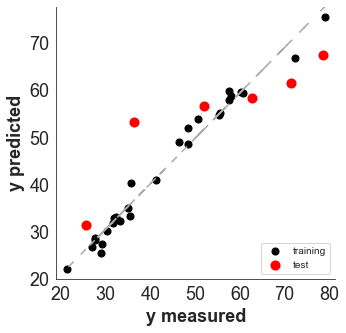



LassoLarsCV
Training R2;Training Q2;Test R2;0.94;0.91;0.79
Number of features used: 9


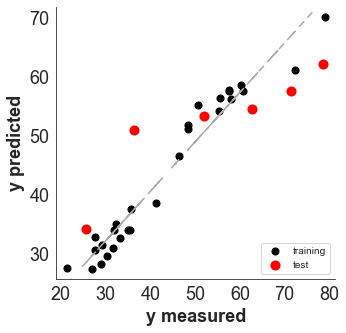

In [116]:
# Lasso feature selection
print("\nSplit method: {}".format(split))
print("Test ratio: {}\n".format(test_ratio))

r2s = []
q2s = []
parms = []
parm_range = np.logspace(-4,1,6)
for parm in parm_range:
    print(parm)
    lasso = Lasso(alpha=parm).fit(X_train_sc, y_train)
    X_train_sel = X_train_sc[:,np.where(lasso.coef_!=0)[0]]
    X_test_sel = X_test_sc[:,np.where(lasso.coef_!=0)[0]]
    try:
        q2,loo_train = loo.q2(X_train_sel,y_train,LinearRegression())
        lr = LinearRegression().fit(X_train_sel,y_train)
        y_pred_train = lr.predict(X_train_sel)
        y_pred_test =  lr.predict(X_test_sel)
        #print("Training R2;Training Q2;Test R2;{:.2f};{:.2f};{:.2f}".format(lr.score(X_train_sel, y_train),q2,metrics.r2_score(y_pred_test,y_test)))
        print("     Training R2;Training Q2;Test R2;{:.2f};{:.2f};{:.2f}".format(lr.score(X_train_sel, y_train),q2,r2_val(y_test,y_pred_test,y_train)))
        #print(lr.score(X_train_sel,y_train),lr.score(X_test_sel,y_test))
    except:
        pass
    print("     Number of features used: {}".format(np.sum(lasso.coef_ != 0)))
    # print(np.where(lr.coef_ != 0)[1])
    
    r2s.append(lasso.score(X_train, y_train))
    q2s.append(q2)
    parms.append(parm)

bestparm = parms[np.argmax(q2s)]
print("\n\nUsing hyperparameter = {}".format(bestparm))
lasso = Lasso(alpha=bestparm).fit(X_train_sc, y_train)
y_pred_train = lasso.predict(X_train_sc)
y_pred_test =  lasso.predict(X_test_sc)
plot_fit(y_train,y_pred_train,y_test,y_pred_test)    
    
# llbic = LassoLarsIC(criterion="bic").fit(X_train_sc, y_train)
# X_train_sel = X_train_sc[:,np.where(llbic.coef_!=0)[0]]
# X_test_sel = X_test_sc[:,np.where(llbic.coef_!=0)[0]]
# print("\n\nLassoLarsIC bic")
# try:
#     q2,loo_train = loo.q2(X_train_sel,y_train,LinearRegression())
#     print("Training R2;Training Q2;Test R2;{:.2f};{:.2f};{:.2f}".format(llbic.score(X_train_sc, y_train),q2,llbic.score(X_test_sc, y_test)))
# except:
#     pass
# print("Number of features used: {}".format(np.sum(llbic.coef_ != 0)))

# llaic = LassoLarsIC(criterion="aic").fit(X_train_sc, y_train)
# X_train_sel = X_train_sc[:,np.where(llaic.coef_!=0)[0]]
# X_test_sel = X_test_sc[:,np.where(llaic.coef_!=0)[0]]
# print("\n\nLassoLarsIC aic")
# try:
#     q2,loo_train = loo.q2(X_train_sel,y_train,LinearRegression())
#     print("Training R2;Training Q2;Test R2;{:.2f};{:.2f};{:.2f}".format(llaic.score(X_train_sc, y_train),q2,llaic.score(X_test_sc, y_test)))
# except:
#     pass
# print("Number of features used: {}".format(np.sum(llaic.coef_ != 0)))

# lassocv = LassoCV(cv=LeaveOneOut()).fit(X_train_sc, y_train)
# X_train_sel = X_train_sc[:,np.where(lassocv.coef_!=0)[0]]
# X_test_sel = X_test_sc[:,np.where(lassocv.coef_!=0)[0]]
# q2,loo_train = loo.q2(X_train_sel,y_train,LinearRegression())
# print("\n\nLassoCV")
# print("Training R2;Training Q2;Test R2;{:.2f};{:.2f};{:.2f}".format(lassocv.score(X_train_sc, y_train),q2,lassocv.score(X_test_sc, y_test)))
# print("Number of features used: {}".format(np.sum(lassocv.coef_ != 0)))
# print(np.where(lassocv.coef_ != 0)[1])

llcv = LassoLarsCV(cv=LeaveOneOut()).fit(X_train_sc, y_train)
X_train_sel = X_train_sc[:,np.where(llcv.coef_!=0)[0]]
X_test_sel = X_test_sc[:,np.where(llcv.coef_!=0)[0]]
q2,loo_train = loo.q2(X_train_sel,y_train,LinearRegression())
print("\n\nLassoLarsCV")
print("Training R2;Training Q2;Test R2;{:.2f};{:.2f};{:.2f}".format(llcv.score(X_train_sc, y_train),q2,r2_val(y_test,y_pred_test,y_train)))
print("Number of features used: {}".format(np.sum(llcv.coef_ != 0)))
# print(np.where(llcv.coef_ != 0)[1])
y_pred_train = llcv.predict(X_train_sc)
y_pred_test =  llcv.predict(X_test_sc)
plot_fit(y_train,y_pred_train,y_test,y_pred_test)    



## Elastic Net


Split method: y_equidist
Test ratio: 0.2



ElasticNetCV
Training R2;Training Q2;Test R2;0.98;0.90;0.78
Number of features used: 42
Best hyperparameters: l1_ratio = 0.66, alpha = 0.1788649529057435


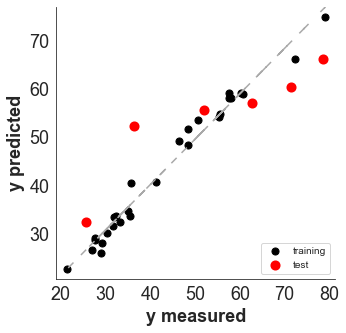

Wall time: 648 ms


In [118]:
%%time
print("\nSplit method: {}".format(split))
print("Test ratio: {}\n".format(test_ratio))

encv = ElasticNetCV(l1_ratio=[.01,.05,.66,.1,.2,.3, .5, .7, .9, .95, .99, 1],
#                     n_alphas=500,
                    alphas=np.logspace(-1,4,100),
                    cv=3,n_jobs=-1,max_iter=1000000).fit(X_train_sc, y_train)
X_train_sel = X_train_sc[:,np.where(encv.coef_!=0)[0]]
X_test_sel = X_test_sc[:,np.where(encv.coef_!=0)[0]]
q2,loo_train = loo.q2(X_train_sel,y_train,Ridge(alpha=encv.alpha_))
y_pred_train = encv.predict(X_train_sc)
y_pred_test =  encv.predict(X_test_sc)
print("\n\nElasticNetCV")
print("Training R2;Training Q2;Test R2;{:.2f};{:.2f};{:.2f}".format(encv.score(X_train_sc, y_train),q2,r2_val(y_test,y_pred_test,y_train)))
print("Number of features used: {}".format(np.sum(encv.coef_ != 0)))
print("Best hyperparameters: l1_ratio = {}, alpha = {}".format(encv.l1_ratio_,encv.alpha_))


plot_fit(y_train,y_pred_train,y_test,y_pred_test) 


## Orthogonal Matching Pursuit

In [119]:
# Orthogonal Matching Pursuit
print("\nSplit method: {}".format(split))
print("Test ratio: {}\n".format(test_ratio))

parm_range = range(1,10)
print(np.shape(X_train_sc))
print(np.shape(y_train))
for parm in parm_range:
    print(parm)
    omp = OrthogonalMatchingPursuit(n_nonzero_coefs=parm).fit(X_train_sc, y_train)
    X_train_sel = X_train_sc[:,np.where(omp.coef_!=0)[0]]
    X_test_sel = X_test_sc[:,np.where(omp.coef_!=0)[0]]
    q2,loo_train = loo.q2(X_train_sel,y_train,LinearRegression())
    y_pred_train = omp.predict(X_train_sc)
    y_pred_test =  omp.predict(X_test_sc)
    print("     Training R2;Training Q2;Test R2;{:.2f};{:.2f};{:.2f}".format(omp.score(X_train_sc, y_train),q2,r2_val(y_test,y_pred_test,y_train)))

    print("     "+" + ".join(["x"+str(i+1) for i in np.where(omp.coef_ != 0)[0]]))
    #print("     Number of features used: {}".format(np.sum(lr.coef_ != 0)))
    

# ompcv = OrthogonalMatchingPursuitCV(cv=LeaveOneOut(),n_jobs=-1).fit(X_train_sc, y_train)
# X_train_sel = X_train_sc[:,np.where(ompcv.coef_!=0)[0]]
# X_test_sel = X_test_sc[:,np.where(ompcv.coef_!=0)[0]]
# q2,loo_train = loo.q2(X_train_sel,y_train,LinearRegression())
# print("\n\nOrthogonalMatchingPursuitCV")
# print("Training R2;Training Q2;Test R2;{:.2f};{:.2f};{:.2f}".format(ompcv.score(X_train_sc, y_train),q2,ompcv.score(X_test_sc, y_test)))
# print("Number of features used: {}".format(np.sum(ompcv.coef_ != 0)))

# print("\n"+" + ".join(["x"+str(i+1) for i in np.where(ompcv.coef_!=0)[0]]))
# print("\n"+" + ".join([X_names[i] for i in np.where(ompcv.coef_!=0)[0]]))

# y_pred_train = ompcv.predict(X_train_sc)
# y_pred_test =  ompcv.predict(X_test_sc)
# plot_fit(y_train,y_pred_train,y_test,y_pred_test)



Split method: y_equidist
Test ratio: 0.2

(28, 190)
(28,)
1
     Training R2;Training Q2;Test R2;0.77;0.73;0.59
     x1
2
     Training R2;Training Q2;Test R2;0.87;0.83;0.60
     x1 + x103
3
     Training R2;Training Q2;Test R2;0.93;0.90;0.80
     x1 + x73 + x103
4
     Training R2;Training Q2;Test R2;0.95;0.91;0.79
     x1 + x73 + x103 + x152
5
     Training R2;Training Q2;Test R2;0.96;0.92;0.80
     x1 + x42 + x73 + x103 + x152
6
     Training R2;Training Q2;Test R2;0.97;0.91;0.75
     x1 + x42 + x73 + x103 + x152 + x158
7
     Training R2;Training Q2;Test R2;0.97;0.94;0.80
     x1 + x42 + x63 + x73 + x103 + x152 + x158
8
     Training R2;Training Q2;Test R2;0.98;0.94;0.79
     x1 + x32 + x42 + x63 + x73 + x103 + x152 + x158
9
     Training R2;Training Q2;Test R2;0.98;0.93;0.81
     x1 + x32 + x42 + x63 + x73 + x103 + x140 + x152 + x158


## Nonlinear Modelling

### Kernel Ridge Regression 


Split method: y_equidist
Test ratio: 0.2



KernelRidge
0.001
     Training R2;Training Q2;Test R2;1.00;0.82;0.74
0.01
     Training R2;Training Q2;Test R2;1.00;0.81;0.70
0.1
     Training R2;Training Q2;Test R2;0.97;0.71;0.60
1.0
     Training R2;Training Q2;Test R2;0.68;-0.01;-0.08
10.0
     Training R2;Training Q2;Test R2;-0.22;-0.87;-0.97
100.0
     Training R2;Training Q2;Test R2;-4.91;-5.36;-3.84
1000.0
     Training R2;Training Q2;Test R2;-8.02;-8.09;-5.75


Using hyperparameter = 0.001


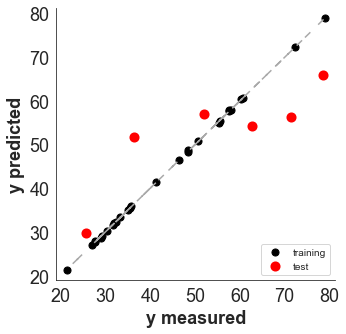

In [120]:
# Kernel Ridge Regression 
# kernel options: linear, poly, rbf
print("\nSplit method: {}".format(split))
print("Test ratio: {}\n".format(test_ratio)) 

r2s = []
q2s = []
parms = []
print("\n\nKernelRidge")

kernel="poly" #rbf (only works if properties are related)
degree=2  #2 simulates crossterms 

parm_range = np.logspace(-3,3,7)
for parm in parm_range:
    print(parm)
    kr = KernelRidge(
        kernel=kernel,
        degree=degree,
        alpha=parm
    ).fit(X_train_sc, y_train)
    y_pred_train = kr.predict(X_train_sc)
    y_pred_test =  kr.predict(X_test_sc)
    q2,loo_train = loo.q2(X_train_sc,y_train,KernelRidge(kernel=kernel,degree=degree,alpha=parm))
    print("     Training R2;Training Q2;Test R2;{:.2f};{:.2f};{:.2f}".format(
        kr.score(X_train_sc, y_train),q2,r2_val(y_test,y_pred_test,y_train)))
    r2s.append(kr.score(X_train, y_train))
    q2s.append(q2)
    parms.append(parm)
    
bestparm = parms[np.argmax(q2s)]
print("\n\nUsing hyperparameter = {}".format(bestparm))
kr = KernelRidge(
        kernel=kernel,
        degree=degree,
        alpha=bestparm
    ).fit(X_train_sc, y_train)
y_pred_train = kr.predict(X_train_sc)
y_pred_test =  kr.predict(X_test_sc)
plot_fit(y_train,y_pred_train,y_test,y_pred_test)



### Support Vector Regression


Split method: y_equidist
Test ratio: 0.2



Support Vector Regression
1.00E-03
     Training R2;Training Q2;Test R2;-0.11;-0.48;-0.29
2.68E-03
     Training R2;Training Q2;Test R2;-0.11;-0.48;-0.29
7.20E-03
     Training R2;Training Q2;Test R2;-0.11;-0.48;-0.29
1.93E-02
     Training R2;Training Q2;Test R2;-0.11;-0.48;-0.29
5.18E-02
     Training R2;Training Q2;Test R2;-0.11;-0.49;-0.30
1.39E-01
     Training R2;Training Q2;Test R2;-0.10;-0.50;-0.32
3.73E-01
     Training R2;Training Q2;Test R2;-0.06;-0.52;-0.35
1.00E+00
     Training R2;Training Q2;Test R2;0.03;-0.56;-0.42
2.68E+00
     Training R2;Training Q2;Test R2;0.10;-0.45;-0.60
7.20E+00
     Training R2;Training Q2;Test R2;0.14;-0.80;-0.92
1.93E+01
     Training R2;Training Q2;Test R2;0.15;-1.47;-1.09
5.18E+01
     Training R2;Training Q2;Test R2;0.19;-2.14;-1.53
1.39E+02
     Training R2;Training Q2;Test R2;0.29;-3.10;-2.95
3.73E+02
     Training R2;Training Q2;Test R2;0.55;-6.64;-8.61
1.00E+03
     Training R2;Training Q2;Te

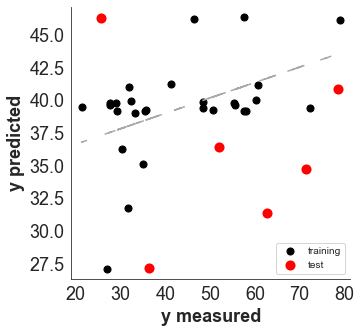

In [121]:
# SVR
print("\nSplit method: {}".format(split))
print("Test ratio: {}\n".format(test_ratio))

r2s = []
q2s = []
parms = []
print("\n\nSupport Vector Regression")

kernel="poly"
degree=2
gamma="auto"

parm_range = np.logspace(-3,3,15)
for parm in parm_range:
    print("{:.2E}".format(parm))
    svr = SVR(
        kernel=kernel,
        degree=degree,
        gamma=gamma,
        C=parm
    ).fit(X_train_sc, y_train)
    y_pred_train = svr.predict(X_train_sc)
    y_pred_test =  svr.predict(X_test_sc)
    q2,loo_train = loo.q2(X_train_sc,y_train,SVR(kernel=kernel,degree=degree,gamma=gamma,C=parm))
    print("     Training R2;Training Q2;Test R2;{:.2f};{:.2f};{:.2f}".format(
        svr.score(X_train_sc, y_train),q2,r2_val(y_test,y_pred_test,y_train)))
    r2s.append(svr.score(X_train, y_train))
    q2s.append(q2)
    parms.append(parm)
    
bestparm = parms[np.argmax(q2s)]
print("\n\nUsing hyperparameter = {}".format(bestparm))
svr = SVR(
        kernel=kernel,
        degree=degree,
        gamma=gamma,
        C=bestparm
    ).fit(X_train_sc, y_train)
y_pred_train = svr.predict(X_train_sc)
y_pred_test =  svr.predict(X_test_sc)
plot_fit(y_train,y_pred_train,y_test,y_pred_test)
   

# keepmodels_[svr] = ()

### Regression with Principal Components


Split method: y_equidist
Test ratio: 0.2

PC Regression 1
Training R2;Training Q2;Test R2;0.03;-0.07;-0.43


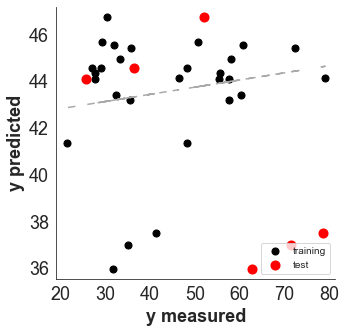


Split method: y_equidist
Test ratio: 0.2

PC Regression 2
Training R2;Training Q2;Test R2;0.12;-0.04;-0.51


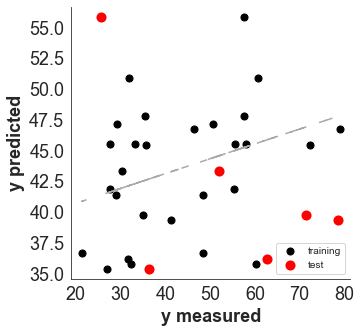


Split method: y_equidist
Test ratio: 0.2

PC Regression 3
Training R2;Training Q2;Test R2;0.14;-0.08;-0.46


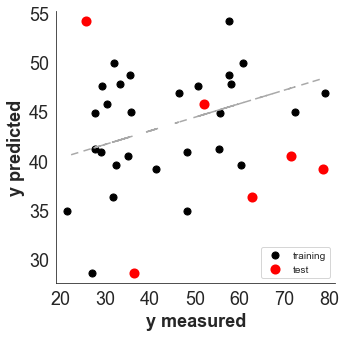


Split method: y_equidist
Test ratio: 0.2

PC Regression 4
Training R2;Training Q2;Test R2;0.16;-0.20;-0.49


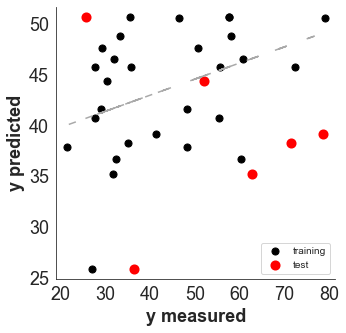


Split method: y_equidist
Test ratio: 0.2

PC Regression 5
Training R2;Training Q2;Test R2;0.22;-0.31;-0.56


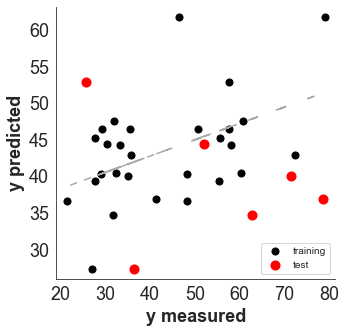


Split method: y_equidist
Test ratio: 0.2

PC Regression 6
Training R2;Training Q2;Test R2;0.22;-0.43;-0.61


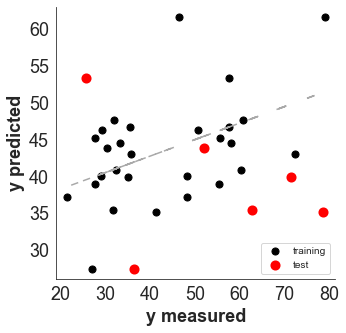


Split method: y_equidist
Test ratio: 0.2

PC Regression 7
Training R2;Training Q2;Test R2;0.24;-0.58;-0.70


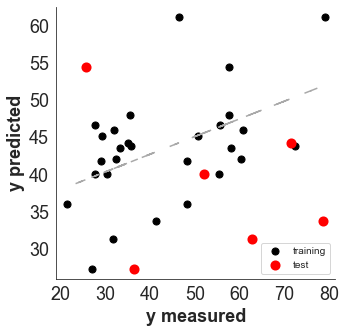


Split method: y_equidist
Test ratio: 0.2

PC Regression 8
Training R2;Training Q2;Test R2;0.28;-0.56;-0.66


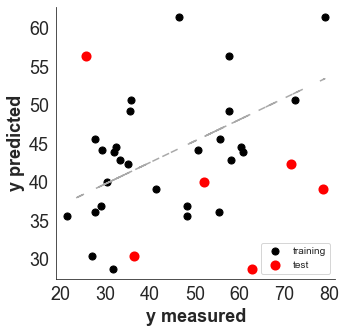

In [124]:
# Regression with Principal Components

for npca in range(1,9):
    pca = PCA(n_components=npca)
    pca.fit(scaler.transform(X_sel))
#     pca.fit(X_train_sc)
    X_train_pca = pca.transform(X_train_sc)
    X_test_pca = pca.transform(X_test_sc)

    pca_score = pca.explained_variance_ratio_
    pca_values = pca.singular_values_
    V = pca.components_

    linr = LinearRegression().fit(X_train_pca, y_train)
#     linr = Ridge(alpha=1).fit(X_train_pca,y_train)
    y_pred_train = linr.predict(X_train_pca)
    y_pred_test =  linr.predict(X_test_pca)
    q2,loo_train = loo.q2(X_train_pca,y_train,LinearRegression())
    print("\nSplit method: {}".format(split))
    print("Test ratio: {}".format(test_ratio))
    print("\nPC Regression {}".format(npca))
    print("Training R2;Training Q2;Test R2;{:.2f};{:.2f};{:.2f}".format(
        linr.score(X_train_pca, y_train),q2,r2_val(y_test,y_pred_test,y_train)))



    plot_fit(y_train,y_pred_train,y_test,y_pred_test)

    
# # virtual screening
# X_screen_sel = pca.transform(X_all_sc)
# y_pred_vscreen = linr.predict(X_screen_sel)
# y_vscreen["PCA5"] = y_pred_vscreen


# keepmodels_[PCA(n_components=2).fit(scaler.transform(X_sel))] = ("n_components=2")

### Random Forest


Split method: y_equidist
Test ratio: 0.2

Training R2;Test R2;0.97;0.55


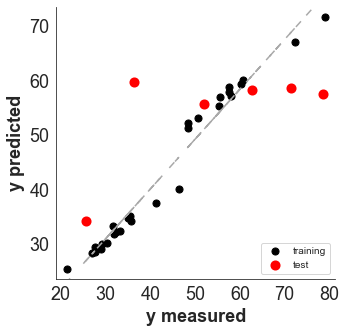

Wall time: 859 ms


In [125]:
%%time
# Random forest regression

rf  = RandomForestRegressor(n_estimators=500,random_state=42,n_jobs=None,max_features=None,max_depth=None).fit(
    X_train_sc, y_train)
# rf = GradientBoostingRegressor(
#     n_estimators=50,
#     subsample=.6,
#     max_depth=2,
#     random_state=42,
#     max_features=None,
#     alpha=0.9,
#     ).fit(X_train_sc, y_train)
y_pred_train = rf.predict(X_train_sc)
y_pred_test =  rf.predict(X_test_sc)
print("\nSplit method: {}".format(split))
print("Test ratio: {}\n".format(test_ratio))
print("Training R2;Test R2;{:.2f};{:.2f}".format(
    rf.score(X_train_sc, y_train),r2_val(y_test,y_pred_test,y_train)))
# print(np.where(llcv.coef_ != 0)[1])

plot_fit(y_train,y_pred_train,y_test,y_pred_test)   

# keepmodels_[rf] = ()